### Import libraries

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import pickle
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

batch_time=500
niters=5000
test_freq=50

activations = {
    'relu':    nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'elu':     nn.ELU(),
    'tanh':    nn.Tanh(),
    'gelu':    nn.GELU(),
    'leaky_relu': nn.LeakyReLU()
}

device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

from misc import preprocessing
_ = preprocessing()

### Import data

In [2]:
file = './data_1D_hypo_500real'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)
    
stress_t,stress_tdt,pl_strain_t,pl_strain_tdt,el_strain_t,el_strain_tdt,strain_t,strain_tdt,energy_t,energy_tdt,dissipation_rate_tdt = data

stress_t = np.expand_dims(stress_t,1)
stress_tdt = np.expand_dims(stress_tdt,1)
pl_strain_t = np.expand_dims(pl_strain_t,1)
pl_strain_tdt = np.expand_dims(pl_strain_tdt,1)
el_strain_t = np.expand_dims(el_strain_t,1)
el_strain_tdt = np.expand_dims(el_strain_tdt,1)
strain_t = np.expand_dims(strain_t,1)
strain_tdt = np.expand_dims(strain_tdt,1)
energy_t = np.expand_dims(energy_t,1)
energy_tdt = np.expand_dims(energy_tdt,1)
dissipation_rate_tdt = np.expand_dims(dissipation_rate_tdt,1)

dstress = stress_tdt - stress_t
dstrain = strain_tdt - strain_t
dstrain_pl = pl_strain_tdt - pl_strain_t
dstrain_el = el_strain_tdt - el_strain_t

#### Split data in paths (batch_time step for each path)

In [3]:
strain_t = np.reshape(strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
strain_tdt = np.reshape(strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain = np.reshape(dstrain,(-1,batch_time,1),order='C')[:,:,:,None]

pl_strain_t = np.reshape(pl_strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
pl_strain_tdt = np.reshape(pl_strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain_pl = np.reshape(dstrain_pl,(-1,batch_time,1),order='C')[:,:,:,None]

el_strain_t = np.reshape(el_strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
el_strain_tdt = np.reshape(el_strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain_el = np.reshape(dstrain_el,(-1,batch_time,1),order='C')[:,:,:,None]

stress_t = np.reshape(stress_t,(-1,batch_time,1),order='C')[:,:,:,None]
stress_tdt = np.reshape(stress_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstress = np.reshape(dstress,(-1,batch_time,1),order='C')[:,:,:,None]

energy_t = np.reshape(energy_t,(-1,batch_time,1),order='C')[:,:,:,None]
energy_tdt = np.reshape(energy_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dissipation_rate_tdt = np.reshape(dissipation_rate_tdt,(-1,batch_time,1),order='C')[:,:,:,None]

data_size = strain_t.shape[0]

#### Split into training, validation, and test sets

In [4]:
train_percentage = .1

ntrain = int(round(data_size * train_percentage))
nval = int(round(data_size * 0.5 *(1.- train_percentage)))
ntest = nval

print("Number of samples: ", data_size)
print("Training samples : ", ntrain)
print("Validation samples : ", nval)
print("Test samples : ", ntest)
print("Total : ", ntest + nval + ntrain)

Number of samples:  20
Training samples :  2
Validation samples :  9
Test samples :  9
Total :  20


In [5]:
strain_t_tv,strain_t_test = _.slice_data(strain_t,ntrain,nval)
strain_tdt_tv,strain_tdt_test = _.slice_data(strain_tdt,ntrain,nval)
pl_strain_t_tv,pl_strain_t_test = _.slice_data(pl_strain_t,ntrain,nval)
pl_strain_tdt_tv,pl_strain_tdt_test = _.slice_data(pl_strain_tdt,ntrain,nval)
dstrain_tv,dstrain_test = _.slice_data(dstrain,ntrain,nval)
dstrain_pl_tv,dstrain_pl_test = _.slice_data(dstrain_pl,ntrain,nval)

stress_t_tv,stress_t_test = _.slice_data(stress_t,ntrain,nval)
stress_tdt_tv,stress_tdt_test = _.slice_data(stress_tdt,ntrain,nval)
dstress_tv,dstress_test = _.slice_data(dstress,ntrain,nval)

energy_t_tv,energy_t_test = _.slice_data(energy_t,ntrain,nval)
energy_tdt_tv,energy_tdt_test = _.slice_data(energy_tdt,ntrain,nval)
dissipation_rate_tdt_tv,dissipation_rate_tdt_test = _.slice_data(dissipation_rate_tdt,ntrain,nval)

#### Compute statistics of the data (for normalization)

In [6]:
prm_e = _.GetParams(strain_tdt_tv)
prm_de = _.GetParams(dstrain_tv)

prm_s = _.GetParams(stress_tdt_tv)
prm_ds = _.GetParams(dstress_tv)

prm_z = _.GetParams(pl_strain_tdt_tv)
prm_dz = _.GetParams(dstrain_pl_tv)

prm_f = _.GetParams(energy_tdt_tv)
prm_d = _.GetParams(dissipation_rate_tdt_tv)

### TANN 

In [7]:
class TANN(nn.Module):

    def __init__(self,params_z,params_f,dtype=torch.float32):
        super(TANN, self).__init__()
        
        self.dtype = dtype
        i_NNz,o_NNz,h_NNz,act_NNz = params_z
        i_NNf,o_NNf,h_NNf,act_NNf = params_f
        
        
        self.NNz = self.constructor(i_NNz,
                                    o_NNz,
                                    h_NNz,
                                    act_NNz)
        
        self.NNf = self.constructor(i_NNf,
                                    o_NNf,
                                    h_NNf,
                                    act_NNf)
        
    def constructor(self, i_dim, o_dim, h_dim, act):
        dim = i_dim
        layers = torch.nn.Sequential()
        for hdim in h_dim:
            layers.append(nn.Linear(dim, hdim, dtype=self.dtype))
            layers.append(activations[act])
            dim = hdim
        layers.append(nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers
    
    def Normalize(self,inputs,prm):
        '''
        Normalize features
        :inputs : data
        :prm : normalization parameters
        '''
        return torch.divide(torch.add(inputs, -prm[1]), prm[0])
    
    def DeNormalize(self,outputs,prm):
        '''
        Denormalize features
        :output : dimensionless data
        :prm : normalization parameters
        '''
        return torch.add(torch.multiply(outputs, prm[0]), prm[1])
    
    def forward(self,inp):
        inp = torch.autograd.Variable(inp,requires_grad=True)
        n_strain_t, n_pl_strain_t, n_dstrain = inp[:,0,None],inp[:,1,None],inp[:,2,None]
        
        # Normalize
        strain_t = self.DeNormalize(n_strain_t,prm_e)
        pl_strain_t = self.DeNormalize(n_pl_strain_t,prm_z)
        dstrain = self.DeNormalize(n_dstrain,prm_de)
        strain_tdt = strain_t+dstrain
        N_strain_tdt = self.Normalize(strain_tdt,prm_e)
        
        
        # Predict evolution law
        npl_dstrain = self.NNz(torch.cat((n_strain_t,n_pl_strain_t,n_dstrain),1))
        pl_dstrain = self.DeNormalize(npl_dstrain,prm_dz)
        pl_strain_tdt = pl_dstrain+pl_strain_t
        n_pl_strain_tdt = self.Normalize(pl_strain_tdt,prm_z)
        
        
        # Predict energy, stress, and dissipation rate
        n_energy_tdt = self.NNf(torch.cat((n_pl_strain_tdt,N_strain_tdt),1))
        energy_tdt = self.DeNormalize(n_energy_tdt,prm_f)
        
        
        
        # Stress
        stress_tdt = torch.autograd.grad(energy_tdt,strain_tdt,
                                     grad_outputs=torch.ones_like(strain_tdt),
                                     retain_graph=True,
                                     create_graph=True)[0]
        n_stress_tdt = self.Normalize(stress_tdt,prm_s)
        
        # Dissipation rate
        thermo_stress = -torch.autograd.grad(energy_tdt,pl_strain_tdt,
                                     grad_outputs=torch.ones_like(pl_strain_tdt),
                                     retain_graph=True,
                                     create_graph=True)[0]
        dissipation_tdt = thermo_stress*pl_dstrain
        n_dissipation_tdt = self.Normalize(dissipation_tdt,prm_d)
        
        return torch.cat((npl_dstrain,n_energy_tdt,n_stress_tdt,n_dissipation_tdt),1)

In [8]:
dtype=torch.float64
NNf_params = [3,1,[32,32,32],'relu']
NNu_params = [2,1,[144,144],'gelu']
TANNnet = TANN(NNf_params,NNu_params,dtype).to(device)
TANNnet.to(torch.double)

TANN(
  (NNz): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (NNf): Sequential(
    (0): Linear(in_features=2, out_features=144, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=144, out_features=144, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=144, out_features=1, bias=True)
  )
)

### Normalize datasets and assemble inputs and outputs

In [9]:
strain_t_tv = TANNnet.Normalize(torch.tensor(strain_t_tv),prm_e)
strain_tdt_tv = TANNnet.Normalize(torch.tensor(strain_tdt_tv),prm_e)
pl_strain_t_tv = TANNnet.Normalize(torch.tensor(pl_strain_t_tv),prm_z)
pl_strain_tdt_tv = TANNnet.Normalize(torch.tensor(pl_strain_tdt_tv),prm_z)
stress_tdt_tv = TANNnet.Normalize(torch.tensor(stress_tdt_tv),prm_s)

energy_tdt_tv = TANNnet.Normalize(torch.tensor(energy_tdt_tv),prm_f)
dissipation_rate_tdt_tv = TANNnet.Normalize(torch.tensor(dissipation_rate_tdt_tv),prm_d)

dstrain_tv = TANNnet.Normalize(torch.tensor(dstrain_tv),prm_de)
dstrain_pl_tv = TANNnet.Normalize(torch.tensor(dstrain_pl_tv),prm_dz)
dstress_tv = TANNnet.Normalize(torch.tensor(dstress_tv),prm_ds)

strain_t_test = TANNnet.Normalize(torch.tensor(strain_t_test),prm_e)
strain_tdt_test = TANNnet.Normalize(torch.tensor(strain_tdt_test),prm_e)
pl_strain_t_test = TANNnet.Normalize(torch.tensor(pl_strain_t_test),prm_z)
pl_strain_tdt_test = TANNnet.Normalize(torch.tensor(pl_strain_tdt_test),prm_z)
stress_tdt_test = TANNnet.Normalize(torch.tensor(stress_tdt_test),prm_s)

energy_tdt_test = TANNnet.Normalize(torch.tensor(energy_tdt_test),prm_f)
dissipation_rate_tdt_test = TANNnet.Normalize(torch.tensor(dissipation_rate_tdt_test),prm_d)

dstrain_test = TANNnet.Normalize(torch.tensor(dstrain_test),prm_de)
dstrain_pl_test = TANNnet.Normalize(torch.tensor(dstrain_pl_test),prm_dz)
dstress_test = TANNnet.Normalize(torch.tensor(dstress_test),prm_ds)


In [10]:
input_tv = torch.cat((strain_t_tv,pl_strain_t_tv,dstrain_tv),-1).to(device)
output_tv = torch.cat((dstrain_pl_tv,energy_tdt_tv,stress_tdt_tv,dissipation_rate_tdt_tv),-1).to(device)

input_test = torch.cat((strain_t_test,pl_strain_t_test,dstrain_test),-1).to(device)
output_test = torch.cat((dstrain_pl_test,energy_tdt_test,stress_tdt_test,dissipation_rate_tdt_test),-1).to(device)

### Training 

In [13]:
learningRate = 1.e-4
optimizer = optim.NAdam(TANNnet.parameters(),
                        lr=learningRate)
loss_hist = []

if not os.path.exists("plots"):
    os.makedirs("plots")

for itr in range(1, niters + 1):
    if itr % test_freq==0:
        fig, ax = plt.subplots(figsize=(1.5,1.5))
    loss_value = 0.
    loss=0.
    for i in range(ntrain):
        
        # Make predictions and backpropagate loss for each path
        
        pred = TANNnet.forward(input_tv[i,:,0])
        
        # loss on evolution equation
        loss = loss_fn(pred[:,0],output_tv[i,:,0,0])
        # loss on energy
        loss += loss_fn(pred[:,1],output_tv[i,:,0,1])
        # loss on stress
        loss += loss_fn(pred[:,2],output_tv[i,:,0,2])
        # loss on dissipation rate
        loss += loss_fn(pred[:,3],output_tv[i,:,0,3])

        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
        
        loss_value+=loss.item() 
        
        if itr % test_freq==0:
            # Plot stress target values and predictions
            ax.plot(strain_t_tv[i,:,0],output_tv[i,:,0,2].cpu().numpy(),color='darkblue',alpha=0.5,linestyle='-',linewidth=0.5)
            ax.plot(strain_t_tv[i,:,0],pred.detach()[:,2].cpu().numpy(),color='red')
    
    loss_hist.append(loss_value)

    if itr % 10 == 0: # Print loss every 10 iterations
        print("Iteration:", itr, " Average Loss:", np.float32(loss_value/ntrain))

    if itr % test_freq==0: 
        plt.savefig("plots/plot_"+str(itr)+".png", dpi=300)
        plt.close()

Iteration: 10  Average Loss: 3.753653
Iteration: 20  Average Loss: 3.7439678
Iteration: 30  Average Loss: 3.7363946
Iteration: 40  Average Loss: 3.7303817
Iteration: 50  Average Loss: 3.72502
Iteration: 60  Average Loss: 3.71993
Iteration: 70  Average Loss: 3.7148955
Iteration: 80  Average Loss: 3.7097962
Iteration: 90  Average Loss: 3.704639
Iteration: 100  Average Loss: 3.6993105
Iteration: 110  Average Loss: 3.693809


KeyboardInterrupt: 

#### Plot loss history

[]

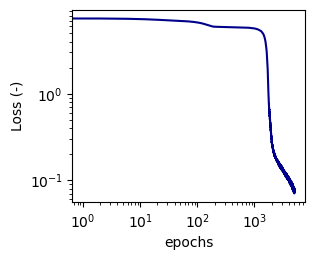

In [ ]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.loglog(loss_hist,color='darkblue')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss (-)')
plt.plot()

### Model at inference (test set)

In [ ]:
# Make predictions for test data
for i in range(ntest):        
    if i == 0:
        pred_test = TANNnet.forward(input_test[i,:,0])
        pred_test = pred_test[None,:,:]
    else:
        pred_test_i = TANNnet.forward(input_test[i,:,0])
        pred_test = torch.cat((pred_test,pred_test_i[None,:,:]),0)
        
pred_test = pred_test.cpu().detach()

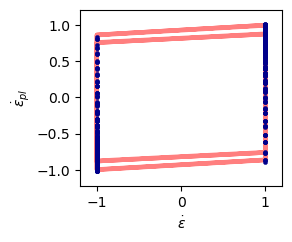

In [ ]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.margins(x=0.1, y = 0.1)
for i in np.arange(1):
    ax.plot(dstrain_test[i,:,:,0],dstrain_pl_test[i,:,0,0],color='red',
            alpha=0.5,linewidth=3,label='ref')
    ax.plot(dstrain_test[i,:,0],pred_test[i,:,0],alpha=1,linewidth=0,markersize=3,color='darkblue',
            marker='o',label='pred',markeredgewidth=0.3, linestyle='-')
ax.set_ylabel('$\dot{\\varepsilon}_{pl}$')
ax.set_xlabel('$\dot{\\varepsilon}$')
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.5)
plt.show()

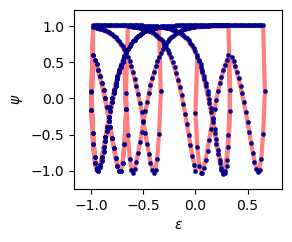

In [ ]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.margins(x=0.1, y = 0.1)
for i in np.arange(1):
    ax.plot(strain_t_test[i,:,:,0],energy_tdt_test[i,:,0,0],color='red',
            alpha=0.5,linewidth=3,label='ref')
    ax.plot(strain_t_test[i,:,0],pred_test[i,:,1],alpha=1,linewidth=0,markersize=3,color='darkblue',
            marker='o',label='pred',markeredgewidth=0.3, linestyle='-')
ax.set_ylabel('$\psi$')
ax.set_xlabel('$\\varepsilon$')
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.5)
plt.show()

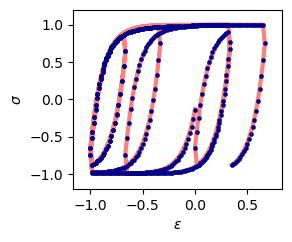

In [ ]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.margins(x=0.1, y = 0.1)
for i in np.arange(1):
    ax.plot(strain_t_test[i,:,:,0],stress_tdt_test[i,:,0,0],color='red',
            alpha=0.5,linewidth=3,label='ref')
    ax.plot(strain_t_test[i,:,0],pred_test[i,:,2],alpha=1,linewidth=0,markersize=3,color='darkblue',
            marker='o',label='pred',markeredgewidth=0.3, linestyle='-')
ax.set_ylabel('$\sigma$')
ax.set_xlabel('$\\varepsilon$')
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.5)
plt.show()

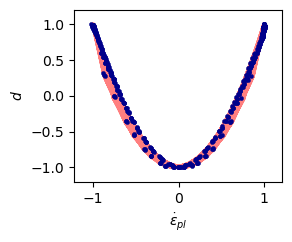

In [ ]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.margins(x=0.1, y = 0.1)
for i in np.arange(1):
    ax.plot(dstrain_pl_test[i,:,0,0],dissipation_rate_tdt_test[i,:,0,0],color='red',
            alpha=0.5,linewidth=3,label='ref')
    ax.plot(pred_test[i,:,0],pred_test[i,:,3],alpha=1,linewidth=0,markersize=3,color='darkblue',
            marker='o',label='pred',markeredgewidth=0.3, linestyle='-')
ax.set_ylabel('$d$')
ax.set_xlabel('$\dot{\\varepsilon}_{pl}$')
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.5)
plt.show()